# modèle génératif

In [ ]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N = 256 # number of factors
n_classes = 10 # number of classes
N_batch = 4
seed = 1973

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix

def psychometric_function(W, factors):
    print(W.shape, factors.shape)
    logit = (factors @ W[:-1, :]) + W[-1, :]
    return 1 / (1 + np.exp(-logit))

def get_data(W, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    factors = np.random.randn(N_batch, N)
    p = psychometric_function(W, factors)
    y = p > np.random.rand(N_batch, n_classes)  # generate data
    
    return factors, p, y

In [ ]:
factors = np.random.randn(N_batch, N)
factors.shape

In [ ]:
W.shape

In [ ]:
(factors@W[:-1, :]).shape

In [ ]:
((factors@W[:-1, :]) + W[-1, :]).shape

In [ ]:
psychometric_function(W, factors)

In [ ]:
factors, p, y = get_data(W, seed, N_batch)
factors.shape, p.shape, y.shape

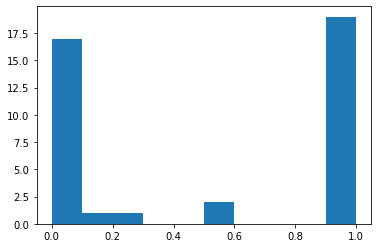

In [ ]:
plt.hist(p.ravel(), bins=10)

# inversion

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid(n_classes)

    def forward(self, factors):
        return self.nl(self.linear(factors))

In [ ]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

In [ ]:
logistic_model = LogisticRegressionModel(N, n_classes)

In [ ]:
factors = torch.randn(N_batch, N)
outputs = logistic_model(factors)

In [ ]:
def fit_data(factors, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = factors.shape[0]
    N = factors.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

In [ ]:
factors, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(factors, y, verbose=True)
print("Final loss =", loss)